In [1]:
##########      zero rate cal        ############
def calEnergy(wave_data,frmae_len):
    """
    :param wave_data: binary data of audio file
    :return: energy
    """
    energy = []
    sum = 0
    frmae_len=np.int32(frmae_len)
    for i in range(len(wave_data)):
        sum = sum + (int(wave_data[i]) * int(wave_data[i]))
        if (i + 1) % frmae_len == 0:
            energy.append(sum)
            sum = 0
        elif i == len(wave_data) - 1:
            energy.append(sum)
    return energy

In [2]:
def calZeroCrossingRate(wave_data,frmae_len):
    """
    :param wave_data: binary data of audio file
    :return: ZeroCrossingRate
    """
    zeroCrossingRate = []
    sum = 0
    frmae_len=np.int32(frmae_len)
    for i in range(len(wave_data)):
        sum = sum + np.abs(int(wave_data[i] >= 0) - int(wave_data[i - 1] >= 0))
        if (i + 1) % frmae_len == 0:
            zeroCrossingRate.append(float(sum) / (frmae_len-1))
            sum = 0
        elif i == len(wave_data) - 1:
            zeroCrossingRate.append(float(sum) / (frmae_len-1))
    return zeroCrossingRate

In [3]:
# 利用短时能量，短时过零率，使用双门限法进行端点检测
def endPointDetect(energy, zeroCrossingRate) :
    sum = 0
    energyAverage = 0
    for en in energy :
        sum = sum + en
    energyAverage = sum / len(energy)

    sum = 0
    for en in energy[:5] :
        sum = sum + en
    ML = sum / 5                        
    MH = energyAverage / 4              #较高的能量阈值
    ML = (ML + MH) / 4    #较低的能量阈值
    sum = 0
    for zcr in zeroCrossingRate[:5] :
        sum = float(sum) + zcr             
    Zs = sum / 5                     #过零率阈值

    A = []
    B = []
    C = []

    # 首先利用较大能量阈值 MH 进行初步检测
    flag = 0
    for i in range(len(energy)):
        if len(A) == 0 and flag == 0 and energy[i] > MH :
            A.append(i)
            flag = 1
        elif flag == 0 and energy[i] > MH and i - 21 > A[len(A) - 1]:
            A.append(i)
            flag = 1
        elif flag == 0 and energy[i] > MH and i - 21 <= A[len(A) - 1]:
            A = A[:len(A) - 1]
            flag = 1

        if flag == 1 and energy[i] < MH :
            A.append(i)
            flag = 0
    # print("较高能量阈值，计算后的浊音A:" + str(A))

    # 利用较小能量阈值 ML 进行第二步能量检测
    for j in range(len(A)) :
        i = A[j]
        if j % 2 == 1 :
            while i < len(energy) and energy[i] > ML :
                i = i + 1
            B.append(i)
        else :
            while i > 0 and energy[i] > ML :
                i = i - 1
            B.append(i)
    # print("较低能量阈值，增加一段语言B:" + str(B))

    # 利用过零率进行最后一步检测
    for j in range(len(B)) :
        i = B[j]
        if j % 2 == 1 :
            while i < len(zeroCrossingRate) and zeroCrossingRate[i] >= 3 * Zs :
                i = i + 1
            C.append(i)
        else :
            while i > 0 and zeroCrossingRate[i] >= 3 * Zs :
                i = i - 1
            C.append(i)
    # print("过零率阈值，最终语音分段C:" + str(C))
    return C

In [4]:
##########      for recognize        ############
def pre_operate(sig,frame_len):
    '''预处理集总'''
    # 过零率检测
    zr=calZeroCrossingRate(sig,frame_len)
    en=calEnergy(sig,frame_len)
    C=endPointDetect(en,zr)
    if((len(C)%2)==1):
            C.append(int(len(sig)/frame_len))
    D=np.array(C)*frame_len
    
    print(D)
    dif=list(D[1::2]-D[0::2])
    loc=dif.index(max(dif))*2
    sig0=np.array(sig[D[loc]:D[loc+1]])
    print("有效语音段:",C[loc],C[loc+1])
       
    min0=np.min(sig0)
    max0=np.max(sig0)
    scale =np.double(max0 - min0)/32767.0
    data_int = ((sig0 - min0) / scale)
    sig2 =np.array(np.rint(data_int),dtype=np.int16)
    
    return sig2

In [5]:
def mfcccal(overlaypath,signal):
    """
    使用Overlay调用MFCC提取硬件部分电路
    """
    np.set_printoptions(suppress=True) 

    overlay0=Overlay(overlaypath)
    x=overlay0.axi_dma_0
    xlnk = Xlnk()
        
    len0=len(signal)
    len1=(int(np.ceil(len0/500))*2-1)*12
    
    mfcc=np.zeros(len1, dtype=np.int16)
    
    input_buffer = xlnk.cma_array(shape=(len0*2,), dtype=np.int16)
    output_buffer = xlnk.cma_array(shape=(len1,), dtype=np.int16)  
    
    for i in range(len0):
        input_buffer[i] = signal[i]

    start = time.time()
    x.sendchannel.transfer(input_buffer)    
    
    x.recvchannel.transfer(output_buffer)
    
    end = time.time()
    
    for i in range(len1):
         mfcc[i]=output_buffer[i] 

    print('time cost ' + str(round(end - start, 8)) + 's')
    cost = round(end - start, 8)
    speed = round(len0/cost,8)
    print('transfer speed: ' + str(speed) + 'sample/s')
    return mfcc

[33000 43000]
有效语音段: 66 86
time cost 0.00031972s
transfer speed: 12510947.07869386sample/s


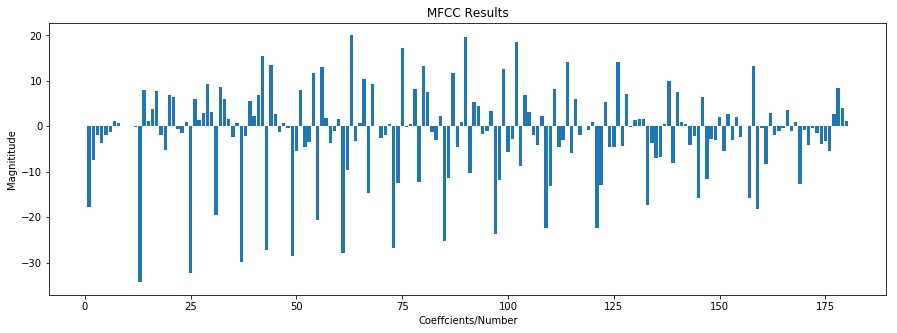

In [6]:
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt 
import time

from pynq.lib import dma
from pynq import Overlay
from pynq import Xlnk



ovlpath="/home/xilinx/jupyter_notebooks/test0/mfcc/design_1_wrapper.bit"
(rate,sig)=wav.read("/home/xilinx/jupyter_notebooks/voice/voice/voice_for_test/3.wav")


sig2=(pre_operate(np.array(sig,dtype=np.double),500))[0:3999]
sig1=np.insert(sig2,0,0)
l1=len(sig1)

a=np.array(mfcccal(ovlpath,sig1),dtype=np.int16)
a1=(a/32)

np.savetxt('/home/xilinx/jupyter_notebooks/test0/mfcc_rslt.txt',a1)



%matplotlib inline 
np.savetxt('/home/xilinx/jupyter_notebooks/test0/a_for_test.txt',a,fmt=['%d'])

l00=len(a1)
l1=np.linspace(1,l00,l00)
plt.figure(num=None, figsize=(15, 5)) 
plt.bar(l1,a1) 
plt.title("MFCC Results") 
plt.xlabel("Coeffcients/Number") 
plt.ylabel("Magnititude")  
plt.show()